In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_data = datasets.CIFAR10(
    root="data", train=True, download=True, transform=transforms
)

test_data = datasets.CIFAR10(
    root="data", train=False, download=True, transform=transforms
)

100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


In [5]:
target_names = test_data.classes

In [10]:
test_image = test_data[2][0]
test_label = test_data[2][1]

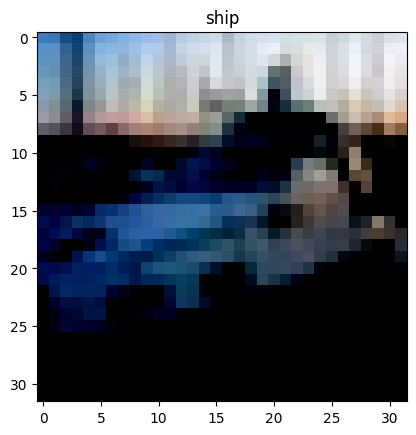

In [11]:
plt.imshow(test_image.permute(1, 2, 0))
plt.title(target_names[test_label])
plt.show()

In [12]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# **Building CNN model. **

In [13]:
import torch
from torch import nn

class BAA32(nn.Module):
    def __init__(self):
        super().__init__()

        # Konvolyutsion qatlamlar
        self.cnns = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  # [3, 32, 32] ➝ [32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # ➝ [32, 16, 16]

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # ➝ [64, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # ➝ [64, 8, 8]
        )

        # Flatten qilish: [64, 8, 8] ➝ [4096]
        self.flatten = nn.Flatten()

        # Klassifikatsiya (Linear qatlamlar)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),  # ➝ [4096 ➝ 128]
            nn.ReLU(),
            nn.Linear(128, 10)          # ➝ [128 ➝ 10] (CIFAR-10 uchun 10 sinf)
        )

    def forward(self, x):
        x = self.cnns(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


In [14]:
model = BAA32()
x = torch.randn(1, 3, 32, 32)  # 1 ta tasodifiy CIFAR-10 rasm
output = model(x)
print(output.shape)  # ➝ torch.Size([1, 10])

torch.Size([1, 10])


In [15]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 🔧 GPU mavjud bo‘lsa, ishlatamiz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📦 Ma'lumotlar transformatsiyasi (normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 🎒 Dataset yuklash
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 🧠 Modelni yaratamiz
model = BAA32().to(device)

# ⚙️ Optimizer va Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
epochs = 5  # qancha marta o‘qitamiz

for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # train rejimga o‘tamiz

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 1.3482
Epoch 2/5, Loss: 0.9628
Epoch 3/5, Loss: 0.8057
Epoch 4/5, Loss: 0.6859
Epoch 5/5, Loss: 0.5853


📊 Test Accuracy: 73.44%


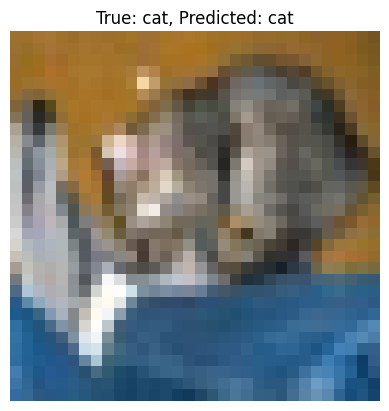

In [17]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()  # baholash rejimi
correct = 0
total = 0

# 🔍 Rasm va bashoratni ko‘rsatish uchun 1 batchni olaylik
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # 🎯 Accuracy hisoblash
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 🔍 Faqat 1 marta rasm ko‘rsatamiz
        sample_image = images[0].cpu()
        sample_label = labels[0].item()
        sample_pred = predicted[0].item()
        break

print(f"📊 Test Accuracy: {100 * correct / total:.2f}%")

# 🖼 Rasm va bashorat
plt.imshow(sample_image.permute(1, 2, 0) * 0.5 + 0.5)
plt.title(f"True: {train_data.classes[sample_label]}, Predicted: {train_data.classes[sample_pred]}")
plt.axis('off')
plt.show()

In [18]:
def predict_single_image(image_path, model, class_names):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # CIFAR10 o‘lchamiga moslash
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # [1, 3, 32, 32]

    model.eval()
    with torch.no_grad():
        output = model(image_tensor.to(device))
        _, predicted = torch.max(output, 1)

    pred_class = class_names[predicted.item()]

    # 🖼 Rasmni ko‘rsatish
    plt.imshow(image)
    plt.title(f"Predicted: {pred_class}")
    plt.axis("off")
    plt.show()

    return pred_class

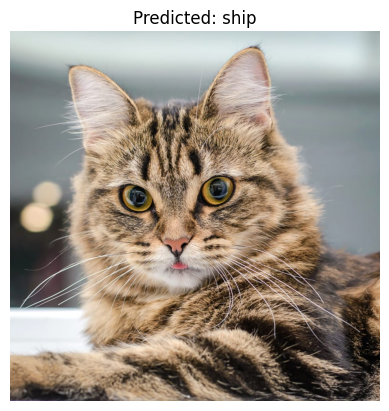

'ship'

In [23]:
# model va class_names tayyor bo‘lishi kerak
image_path = '/content/data/image-79322-800.jpg'  # o‘zingiz yuklagan rasm manzili
class_names = train_data.classes

predict_single_image(image_path, model, class_names)

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [27]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 583M/586M [00:03<00:00, 124MB/s]
100% 586M/586M [00:03<00:00, 157MB/s]


In [28]:
!unzip -q animals10.zip -d animals10

In [30]:
import os

classes = os.listdir("animals10/raw-img")
print("Klasslar:", classes)

Klasslar: ['gatto', 'ragno', 'gallina', 'farfalla', 'cane', 'cavallo', 'elefante', 'mucca', 'pecora', 'scoiattolo']


In [31]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# 🔄 Transformatsiya
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasetni o‘qish
dataset = ImageFolder(root='animals10/raw-img', transform=transform)
class_names = dataset.classes
print("Class names:", class_names)

Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [32]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [33]:
import torch
from torch import nn

class AnimalCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.cnns = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),  # [3, 64, 64] → [32, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),         # [32, 64, 64] → [32, 32, 32]

            nn.Conv2d(32, 64, 3, 1, 1), # [32, 32, 32] → [64, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),         # [64, 32, 32] → [64, 16, 16]

            nn.Conv2d(64, 128, 3, 1, 1),# [64, 16, 16] → [128, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2, 2)          # [128, 16, 16] → [128, 8, 8]
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.cnns(x)
        x = self.flatten(x)
        return self.classifier(x)

In [34]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnimalCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(model, loader):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return running_loss / len(loader), accuracy

def evaluate(model, loader):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return running_loss / len(loader), accuracy

In [35]:
epochs = 5

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    print(f"Epoch {epoch+1}/{epochs} → "
          f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2%} | "
          f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.2%}")

Epoch 1/5 → Train Loss: 1.6612, Accuracy: 41.78% | Test Loss: 1.3414, Accuracy: 54.09%
Epoch 2/5 → Train Loss: 1.1916, Accuracy: 59.48% | Test Loss: 1.2290, Accuracy: 59.22%
Epoch 3/5 → Train Loss: 0.9730, Accuracy: 67.02% | Test Loss: 1.0498, Accuracy: 65.51%
Epoch 4/5 → Train Loss: 0.7745, Accuracy: 73.79% | Test Loss: 1.0013, Accuracy: 68.30%
Epoch 5/5 → Train Loss: 0.5786, Accuracy: 80.27% | Test Loss: 1.0338, Accuracy: 67.93%


In [36]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(path):
    model.eval()
    image = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]

    # Vizual ko‘rsatish
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

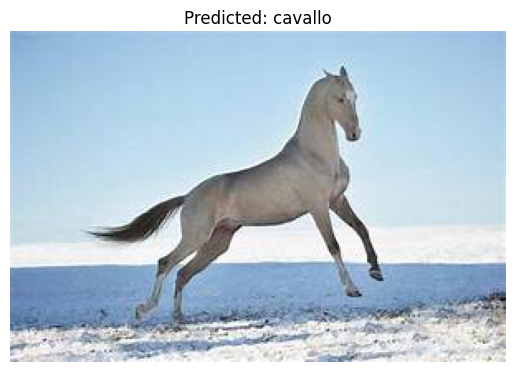

'cavallo'

In [40]:
predict_image("/content/data/horse (12).jpeg")

# **Yangi datasetni o'qitish**

In [3]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d antobenedetti/animals
!unzip -q animals.zip -d animals

Dataset URL: https://www.kaggle.com/datasets/antobenedetti/animals
License(s): GPL-2.0
 98% 864M/882M [00:04<00:00, 224MB/s]
100% 882M/882M [00:04<00:00, 218MB/s]


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import random
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [37]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [42]:
train_dataset = ImageFolder('animals/animals/train', transform=train_transform)
val_dataset = ImageFolder('animals/animals/val', transform=val_transform)
class_names = train_dataset.classes
print("Sinflar:", class_names)

Sinflar: ['cat', 'dog', 'elephant', 'horse', 'lion']


In [43]:
def create_balanced_subset(dataset):
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    min_count = min(len(idxs) for idxs in class_indices.values())
    balanced_indices = []
    for idxs in class_indices.values():
        selected = random.sample(idxs, min_count)
        balanced_indices.extend(selected)

    random.shuffle(balanced_indices)
    return Subset(dataset, balanced_indices)

balanced_train_dataset = create_balanced_subset(train_dataset)

In [44]:
train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [45]:
class AnimalCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnns = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.cnns(x)
        x = self.flatten(x)
        return self.classifier(x)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnimalCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [47]:
def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    return total_loss / len(loader), correct / total

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return total_loss / len(loader), correct / total

In [48]:
def show_confusion_matrix(model, loader, class_names):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

In [49]:
def show_misclassified_images(model, loader, class_names, n=6):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
            for i in range(len(images)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i], labels[i], preds[i]))
                if len(misclassified) >= n:
                    break
            if len(misclassified) >= n:
                break

    rows = math.ceil(n / 3)
    plt.figure(figsize=(12, 4 * rows))
    for i, (img, true, pred) in enumerate(misclassified):
        plt.subplot(rows, 3, i + 1)
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f"True: {class_names[true]}, Pred: {class_names[pred]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [50]:
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2%} | Val Acc={val_acc:.2%}")

Epoch 1: Train Acc=56.04% | Val Acc=74.15%
Epoch 2: Train Acc=75.77% | Val Acc=81.43%
Epoch 3: Train Acc=80.14% | Val Acc=83.03%
Epoch 4: Train Acc=82.90% | Val Acc=86.97%
Epoch 5: Train Acc=84.72% | Val Acc=85.24%
Epoch 6: Train Acc=86.28% | Val Acc=89.25%
Epoch 7: Train Acc=87.03% | Val Acc=88.84%
Epoch 8: Train Acc=88.86% | Val Acc=85.97%
Epoch 9: Train Acc=88.79% | Val Acc=89.65%
Epoch 10: Train Acc=90.31% | Val Acc=87.17%


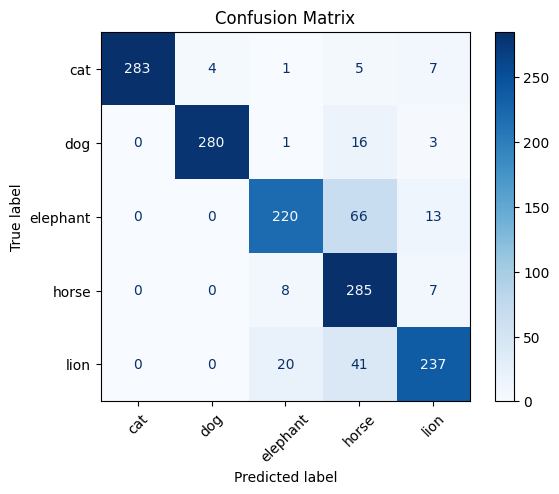

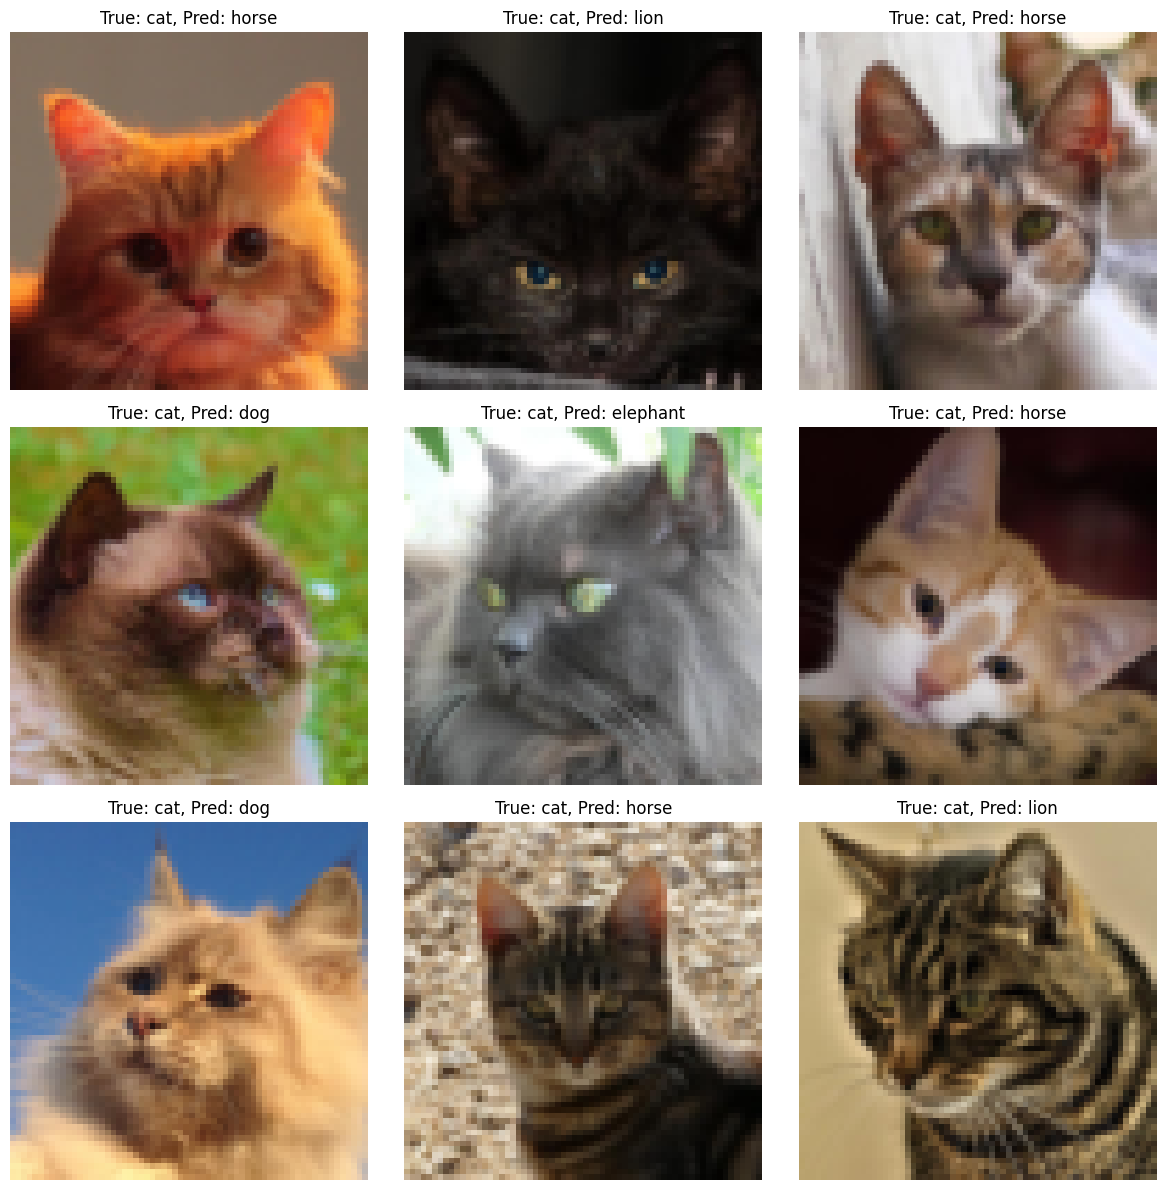

In [51]:
show_confusion_matrix(model, val_loader, class_names)
show_misclassified_images(model, val_loader, class_names, n=9)

In [52]:
torch.save(model.state_dict(), "animal_cnn_model.pt")
from google.colab import files
files.download("animal_cnn_model.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>